In [12]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import time
import scipy
from PIL import Image
from scipy import ndimage

np.random.seed(1)

%matplotlib inline

In [13]:
#sigmoid
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

In [14]:
#relu
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    
    return A, cache

In [15]:
#sigmoid求导
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [83]:
#relu求导
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    
    return dZ

In [84]:
#初始化参数
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #初始化为随机值
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1)) #初始化为0
        
    return parameters

In [85]:
#前向传播中的线性函数
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

In [86]:
#不同激活函数下前向传播
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)

    return A, cache


In [87]:
#L层神经网络模型的前向传播
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                 

    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [88]:
#计算成本函数
def compute_cost(AL, Y):
    m = Y.shape[1]

    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)

    return cost

In [89]:
#反向传播中的线性函数求导
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [90]:
#不同激活函数下反向传播求导
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [91]:
#L层神经网络模型的反向传播
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [92]:
#更新参数
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 

    for l in range(L): 
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]

    return parameters

In [93]:
#计算识别准确度
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("预测准确度: "  + str(np.sum((p == y)/m)))
        
    return p

In [94]:
#L层神经网络模型
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                  
    
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
                
        if print_cost and i % 100 == 0:
            print ("循环%i次后的成本值: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [95]:
#导入数据
def load_dataset():
    train_dataset = h5py.File("train_cat.h5","r") #读取训练数据，共209张图片
    test_dataset = h5py.File("test_cat.h5", "r") #读取测试数据，共50张图片
    
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) #原始训练集（209*64*64*3）
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) #原始训练集的标签集（y=0非猫,y=1是猫）（209*1）
    
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) #原始测试集（50*64*64*3
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) #原始测试集的标签集（y=0非猫,y=1是猫）（50*1）
    
    train_set_y_orig = train_set_y_orig.reshape((1,train_set_y_orig.shape[0])) #原始训练集的标签集设为（1*209）
    test_set_y_orig = test_set_y_orig.reshape((1,test_set_y_orig.shape[0])) #原始测试集的标签集设为（1*50）
    
    classes = np.array(test_dataset["list_classes"][:])
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

循环0次后的成本值: 0.771749
循环100次后的成本值: 0.672053
循环200次后的成本值: 0.648263
循环300次后的成本值: 0.611507
循环400次后的成本值: 0.567047
循环500次后的成本值: 0.540138
循环600次后的成本值: 0.527930
循环700次后的成本值: 0.465477
循环800次后的成本值: 0.369126
循环900次后的成本值: 0.391747
循环1000次后的成本值: 0.315187
循环1100次后的成本值: 0.272700
循环1200次后的成本值: 0.237419
循环1300次后的成本值: 0.199601
循环1400次后的成本值: 0.189263
循环1500次后的成本值: 0.161189
循环1600次后的成本值: 0.148214
循环1700次后的成本值: 0.137775
循环1800次后的成本值: 0.129740
循环1900次后的成本值: 0.121225
循环2000次后的成本值: 0.113821
循环2100次后的成本值: 0.107839
循环2200次后的成本值: 0.102855
循环2300次后的成本值: 0.100897
循环2400次后的成本值: 0.092878


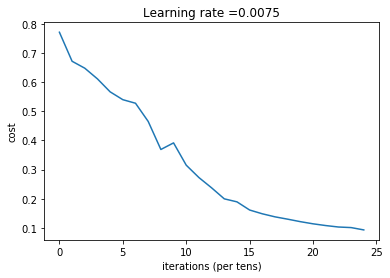

预测准确度: 0.985645933014
预测准确度: 0.8


In [96]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

m_train = train_x_orig.shape[0] #训练集中样本个数
m_test = test_x_orig.shape[0] #测试集总样本个数
num_px = test_x_orig.shape[1] #图片的像素大小

train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0],-1).T #原始训练集的设为（12288*209）
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0],-1).T #原始测试集设为（12288*50）

train_x = train_x_flatten/255. #将训练集矩阵标准化
test_x = test_x_flatten/255. #将测试集矩阵标准化

layers_dims = [12288, 20, 7, 5, 1]
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)

预测准确度: 0.0
y = 1.0, 你的L层神经网络模型检测到它是一张 "cat" 的图片.


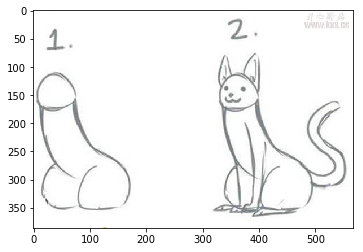

In [56]:
my_image = "my_image.jpg" #改成自己的图片文件名 
my_label_y = [0] #改成自己的图片的标签

image = np.array(ndimage.imread(my_image, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", 你的L层神经网络模型检测到它是一张 \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" 的图片.")